##  Transfer Learning Using Self-supervised Pretraining

- Flowers dataset https://www.kaggle.com/datasets/alxmamaev/flowers-recognition

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We are implementing self-supervised pretraining using SWAV 
on flower dataset

Installing lightning packages and torchmetrics

In [3]:
!pip install lightning-bolts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 316 kB 9.8 MB/s 
     |████████████████████████████████| 585 kB 64.0 MB/s 
     |████████████████████████████████| 419 kB 67.0 MB/s 
     |████████████████████████████████| 140 kB 76.2 MB/s 
     |████████████████████████████████| 596 kB 57.0 MB/s 
     |████████████████████████████████| 1.1 MB 21.4 MB/s 
     |████████████████████████████████| 144 kB 73.4 MB/s 
     |████████████████████████████████| 271 kB 69.3 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Importing required libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
import pl_bolts
import torchvision
import torchmetrics
import pytorch_lightning as pl

from torch.optim import Adam
from torch.nn.functional import cross_entropy
from torchmetrics.functional import accuracy

from torchvision import models
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader

from pytorch_lightning import Callback
from pytorch_lightning.loggers import CSVLogger

In [5]:
class FlowerDataModule(pl.LightningDataModule):
    def __init__(self, data_dir = '/content/drive/MyDrive/flower/flowers'):
        super().__init__()

        self.data_dir = data_dir
        self.transform = transforms.Compose(
          [   
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p = 0.5),
            transforms.RandomVerticalFlip(p = 0.1),
            transforms.RandomRotation(10),
              transforms.ToTensor(),
              transforms.Normalize(
                  mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]
              ),
          ]
        )

    def setup(self, stage= None):
        flower_full = ImageFolder(self.data_dir, transform = self.transform)
    
        length = len(flower_full)
    
        val_split_size = 0.2
        
        train_length = round(length * (1 - val_split_size))
        val_length = length - train_length
    
        self.flower_train, self.flower_val = \
          random_split(flower_full , [train_length, val_length])  

    def train_dataloader(self):
        train_dataloader = \
          DataLoader(self.flower_train, batch_size = 32, shuffle = True)

        return train_dataloader

    def val_dataloader(self):  
        val_dataloader = \
          DataLoader(self.flower_val, batch_size = 32)

        return val_dataloader


In [6]:
flower_dm = FlowerDataModule()

flower_dm.setup()

## Self-Supervised Pretraining with SWAV
Pretrained SWAV model is loaded from specified weight path.Model is frozen for initial 10 epochs.Note that here we are unfreezing our backbone after 10 epochs.Also two feature maps are generated using SWAV model.We are taking only one of them.

https://pytorch-lightning-bolts.readthedocs.io/en/latest/self_supervised_models.html#swav.


In [7]:
from pl_bolts.models.self_supervised import SwAV

class FlowerImageClassifier(pl.LightningModule):
    def __init__(self, num_classes = 5, lr = 1e-3):
        super().__init__()
        self.save_hyperparameters()

        weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/swav/swav_imagenet/swav_imagenet.pth.tar'
        swav = SwAV.load_from_checkpoint(weight_path, strict = True)

        self.backbone = swav.model
        self.finetune_layer = torch.nn.Linear(3000, num_classes)
        
    def training_step(self, batch, batch_idx):
        x, y = batch

        if self.trainer.current_epoch < 10:
            with torch.no_grad():
                  features = self.backbone(x)[-1]
        else:
            features = self.backbone(x)[-1]

        preds = self.finetune_layer(features)

        loss = cross_entropy(preds, y)
        accuracy_score = accuracy(preds, y)

        metrics = {'train_loss': loss, 'train_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True, 
                      prog_bar = True, logger = True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch   

        features = self.backbone(x)[-1]
        preds = self.finetune_layer(features)

        loss = cross_entropy(preds, y)
        accuracy_score = accuracy(preds, y)

        metrics = {'valid_loss': loss, 'valid_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True, 
                      prog_bar = True, logger = True)
        
        return metrics

    def configure_optimizers(self):
        
        optimizer = Adam(self.parameters(), lr = self.hparams.lr)

        return optimizer

CSV Logger is defined to log the metrics into a csv file

In [8]:
logger = CSVLogger(save_dir = './lightning_logs', name = 'swav_bb_unfrozen')

Classifier is called and Trainer is defined and fit with Flower Datamodule.
Training is done for 20 epochs and logger is used for logging metrics

In [ ]:
# classifier = FlowerImageClassifier()

# trainer = pl.Trainer(gpus = 1, max_epochs = 20, logger = logger)

# trainer.fit(classifier, flower_dm)  

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type   | Params
------------------------------------------
0 | backbone       | ResNet | 28.4 M
1 | finetune_layer | Linear | 15.0 K
------------------------------------------
28.4 M    Trainable params
0         Non-trainable params
28.4 M    Total params
113.479   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [9]:
classifier = FlowerImageClassifier()

trainer = pl.Trainer(max_epochs = 20,
                     limit_train_batches = 20, 
                     log_every_n_steps = 10, logger = logger, gpus = 1)

trainer.fit(classifier, flower_dm)  

Downloading: "https://pl-bolts-weights.s3.us-east-2.amazonaws.com/swav/swav_imagenet/swav_imagenet.pth.tar" to /root/.cache/torch/hub/checkpoints/swav_imagenet.pth.tar


  0%|          | 0.00/322M [00:00<?, ?B/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs/swav_bb_unfrozen
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type   | Params
------------------------------------------
0 | backbone       | ResNet | 28.4 M
1 | finetune_layer | Linear | 15.0 K
------------------------------------------
28.4 M    Trainable params
0         Non-trainable params
28.4 M    Total params
113.479   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metrics logged in CSV file are now plotted.

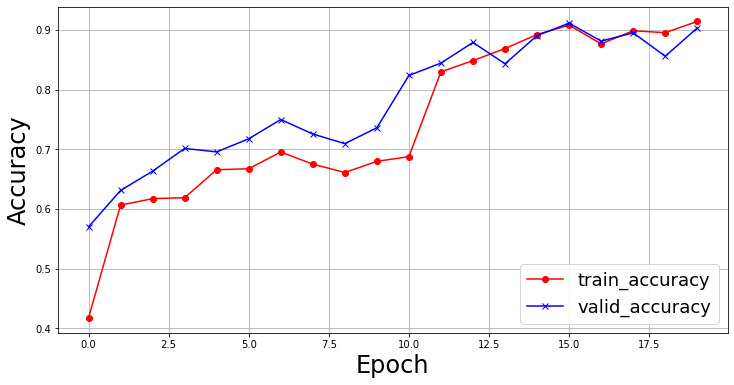

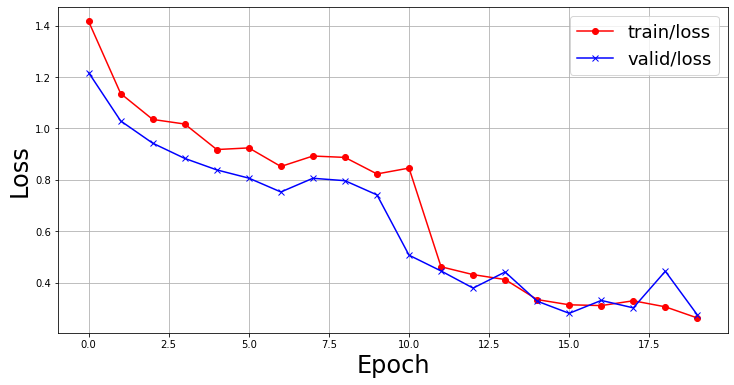

In [10]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
train_acc = metrics['train_acc'].dropna().reset_index(drop = True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)
valid_acc = metrics['valid_acc'].dropna().reset_index(drop = True)
    
fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_acc, color = 'r', marker = 'o', label = 'train_accuracy')
plt.plot(valid_acc, color = 'b', marker = 'x', label = 'valid_accuracy')

plt.ylabel('Accuracy', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'lower right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/acc_ssl_swav.png')

train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)

fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_loss, color = 'r', marker = 'o', label = 'train/loss')
plt.plot(valid_loss, color = 'b', marker = 'x', label = 'valid/loss')

plt.ylabel('Loss', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'upper right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/loss_ssl_swav.png')\

Data augmentation specific to SWAV is applied by following method as train_transforms and val_transforms methods in datamodule are deprecatedLR is applied by following method as train_transforms and val_transforms methods in datamodule are deprecated

In [11]:
class ApplyTransform(Dataset):
   
    def __init__(self, dataset, transform = None):
        self.dataset = dataset
        self.transform = transform
        

    def __getitem__(self, idx):
        sample, target = self.dataset[idx]
        if self.transform is not None:
            sample = self.transform(sample)
        
        return sample, target

    def __len__(self):
        return len(self.dataset)

Transformations for both training and validation data specific to SIMCLR are defined. We have opted for stl10 normalisation. We can also remove normalisation if not needed.
Ref link-
https://pytorch-lightning-bolts.readthedocs.io/en/0.3.0/api/pl_bolts.models.self_supervised.swav.transforms.html#module-pl_bolts.models.self_supervised.swav.transforms

In [12]:
from pl_bolts.models.self_supervised.swav.transforms import (
    SwAVTrainDataTransform, SwAVEvalDataTransform
)
from pl_bolts.transforms.dataset_normalizations import stl10_normalization

train_transform = SwAVTrainDataTransform(normalize = stl10_normalization())

val_transform = SwAVEvalDataTransform(normalize = stl10_normalization())

Modified Datamodule is defined with transformations

In [13]:
class FlowerDataModule(pl.LightningDataModule):
    def __init__(self, train_transform, val_transform, data_dir = '/content/drive/MyDrive/flower/flowers'):
        super().__init__()

        self.data_dir = data_dir
        self.transform = transforms.Compose([torchvision.transforms.Resize((224, 224))])

        self.train_transform = train_transform
        self.val_transform = val_transform

    def setup(self, stage = None):
        flower_full = ImageFolder(self.data_dir, transform = self.transform)
    
        length = len(flower_full)
    
        val_split_size = 0.2
        
        train_length = round(length * (1 - val_split_size))
        val_length = length - train_length
    
        self.flower_train, self.flower_val = \
            random_split(flower_full , [train_length, val_length])

        self.flower_train = ApplyTransform(self.flower_train, transform = self.train_transform)
        self.flower_val = ApplyTransform(self.flower_val, transform = self.val_transform)

    def train_dataloader(self):
        train_dataloader = \
          DataLoader(self.flower_train, batch_size = 32, shuffle = True)

        return train_dataloader

    def val_dataloader(self):  
        val_dataloader = \
          DataLoader(self.flower_val, batch_size = 32)

        return val_dataloader


Datamodule is instantiated and setup called

In [14]:
flower_dm_swav = FlowerDataModule(train_transform , val_transform)

flower_dm_swav.setup()

Training dataloader is obtained and dimension is checked. Note that len(dataloader) gives no. of batches as Dataloader loads images in batch form.

In [15]:
train_dl = flower_dm_swav.train_dataloader()

len(train_dl)

109

Displaying augmented images with those transformations. Three sets of Images are formed. We are showing first set.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


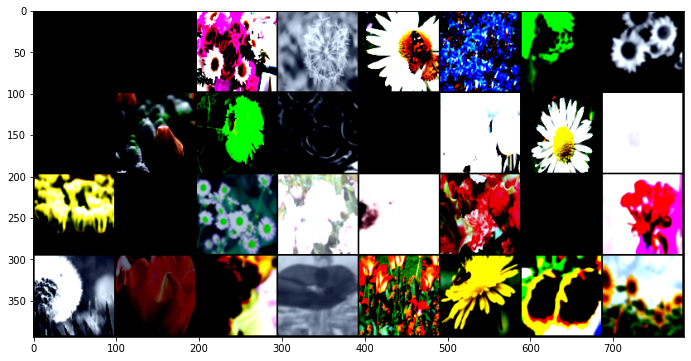

In [16]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (12, 6))
        ax.imshow(make_grid(images[0], nrow = 8).permute(1, 2, 0))
        break

show_batch(train_dl)

Modified CLassifier Module with only one change where x=x[0]

In [17]:

class FlowerImageClassifier(pl.LightningModule):
    def __init__(self, num_classes = 5, lr = 1e-3):
        super().__init__()
        self.save_hyperparameters()

        weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/swav/swav_imagenet/swav_imagenet.pth.tar'
        swav = SwAV.load_from_checkpoint(weight_path, strict = True)

        self.backbone = swav.model
        self.finetune_layer = torch.nn.Linear(3000, num_classes)
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x[0]

        if self.trainer.current_epoch < 10:
            with torch.no_grad():
                  features = self.backbone(x)[-1]
        else:
            features = self.backbone(x)[-1]

        preds = self.finetune_layer(features)

        loss = cross_entropy(preds, y)
        accuracy_score = accuracy(preds, y)

        metrics = {'train_loss': loss, 'train_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True, 
                      prog_bar = True, logger = True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch   
        x = x[0]

        features = self.backbone(x)[-1]
        preds = self.finetune_layer(features)

        loss = cross_entropy(preds, y)
        accuracy_score = accuracy(preds, y)

        metrics = {'valid_loss': loss, 'valid_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True, 
                      prog_bar = True, logger = True)
        
        return metrics

    def configure_optimizers(self):
        
        optimizer = Adam(self.parameters(), lr = self.hparams.lr)

        return optimizer

Model is trained in the same way as earlier with logging.Note that after the model is unfrozen, there is a spike in loss and accuracy gets reduced.

In [18]:
logger = CSVLogger(save_dir = './lightning_logs', name = 'swav_bb_unfrozen_with_swavtransform')

In [19]:
classifier = FlowerImageClassifier()

trainer = pl.Trainer(max_epochs = 20, 
                     limit_train_batches = 20, 
                     log_every_n_steps = 10,
                     logger = logger, gpus = 1)

trainer.fit(classifier, flower_dm_swav)  

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs/swav_bb_unfrozen_with_swavtransform
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type   | Params
------------------------------------------
0 | backbone       | ResNet | 28.4 M
1 | finetune_layer | Linear | 15.0 K
------------------------------------------
28.4 M    Trainable params
0         Non-trainable params
28.4 M    Total params
113.479   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

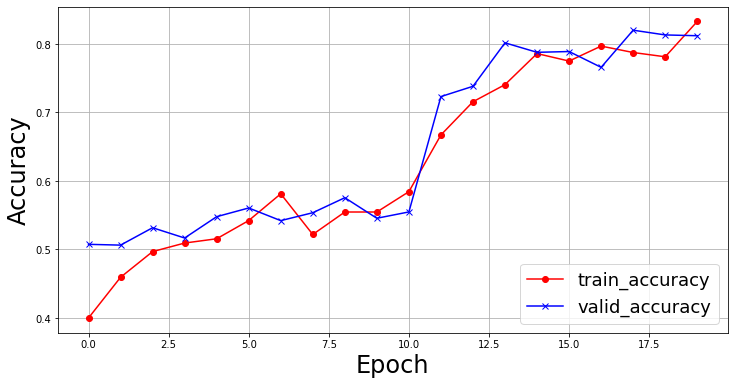

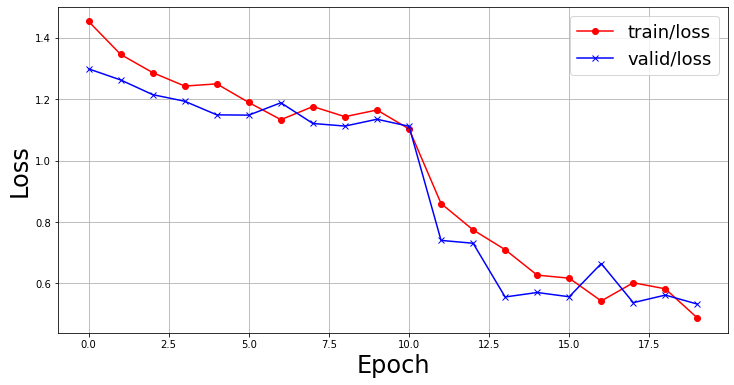

In [20]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
train_acc = metrics['train_acc'].dropna().reset_index(drop = True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)
valid_acc = metrics['valid_acc'].dropna().reset_index(drop = True)
    
fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_acc, color = 'r', marker = 'o', label = 'train_accuracy')
plt.plot(valid_acc, color = 'b', marker = 'x', label = 'valid_accuracy')

plt.ylabel('Accuracy', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'lower right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/acc_ssl_swav_tr.png')

train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)

fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_loss, color = 'r', marker = 'o', label = 'train/loss')
plt.plot(valid_loss, color = 'b', marker = 'x', label = 'valid/loss')

plt.ylabel('Loss', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'upper right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/loss_ssl_swav_tr.png')\

![](img/20201117-1-train_acc.svg "Train Accuracy")

![](img/20201117-1-train_loss.svg "Train Loss")